In [17]:
import pandas as pd  # data frame operations
import sweetviz as sv  # EDA
import numpy as np  # arrays and math functions
from scipy.stats import uniform  # for training-and-test split
#import statsmodels.api as sm  # statistical models (including regression)
import statsmodels.formula.api as smf  # R-like model specification
import matplotlib.pyplot as plt  # 2D plotting
import seaborn as sns  #  PLOTTING
from scipy import stats
sns.set(style="darkgrid") # seaborn style
from statsmodels.graphics.mosaicplot import mosaic

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [18]:
# data from: https://www.kaggle.com/kemical/kickstarter-projects?select=ks-projects-201801.csv
kick_base = pd.read_csv("/content/drive/My Drive/ks_projects_201801.csv", sep=',', error_bad_lines=False)

In [19]:
# below will focus on US data...about 75% of the companies exist within the US
kick1 = kick_base.copy()
kick1 = kick1[kick1['country'].isin(['US'])]

kick1['percent_pledged'] = kick1['usd_pledged_real']/kick1['usd_goal_real']

# converting to datetime so we can calculate how many days between start and end date
kick1['deadline'] = pd.to_datetime(kick1['deadline'])
kick1['launched'] = pd.to_datetime(kick1['launched'])
kick1['fundraising_length'] = kick1['deadline'] - kick1['launched']

# https://stackoverflow.com/questions/37840812/pandas-subtracting-two-date-columns-and-the-result-being-an-integer
# calculating how many days kickstarters gave invest community
kick1['fundraising_length'] = kick1['fundraising_length']/ np.timedelta64(1, 'D')

# calculating the amount of $/funding period requested
kick1['funds_to_length'] = kick1['goal']/kick1['fundraising_length']

kick1.dtypes

ID                             int64
name                          object
category                      object
main_category                 object
currency                      object
deadline              datetime64[ns]
goal                         float64
launched              datetime64[ns]
pledged                      float64
state                         object
backers                        int64
country                       object
usd pledged                  float64
usd_pledged_real             float64
usd_goal_real                float64
percent_pledged              float64
fundraising_length           float64
funds_to_length              float64
dtype: object

In [20]:
kick1.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,percent_pledged,fundraising_length,funds_to_length
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:00,2421.0,failed,15,US,100.0,2421.0,30000.0,0.080700,59.803472,501.643113
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:00,220.0,failed,3,US,220.0,220.0,45000.0,0.004889,44.986111,1000.308737
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:00,1.0,failed,1,US,1.0,1.0,5000.0,0.000200,29.858333,167.457438
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:00,1283.0,canceled,14,US,1283.0,1283.0,19500.0,0.065795,55.642361,350.452418
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:00,52375.0,successful,224,US,52375.0,52375.0,50000.0,1.047500,34.431944,1452.139889


In [21]:
# https://stackoverflow.com/questions/13539968/how-can-i-find-the-dimensions-of-a-matrix-in-python 
np.shape(kick1)  # shape should be 292,627 if looking at US only

(292627, 18)

In [22]:
# removing anything that is in the state of: 'live,' 'undefined,' or 'suspended'
kick1 = kick1[kick1['state'].isin(['failed','successful','canceled'])]
np.shape(kick1) # shape should have 289,671 rows if looking at US 

(289671, 18)

In [23]:
# making it so that we only have 2 variables in the project "state" column
kick1['state'] = kick1['state'].replace({'canceled': 'failed'})
kick1.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,percent_pledged,fundraising_length,funds_to_length
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:00,2421.0,failed,15,US,100.0,2421.0,30000.0,0.080700,59.803472,501.643113
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:00,220.0,failed,3,US,220.0,220.0,45000.0,0.004889,44.986111,1000.308737
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:00,1.0,failed,1,US,1.0,1.0,5000.0,0.000200,29.858333,167.457438
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:00,1283.0,failed,14,US,1283.0,1283.0,19500.0,0.065795,55.642361,350.452418
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:00,52375.0,successful,224,US,52375.0,52375.0,50000.0,1.047500,34.431944,1452.139889


In [24]:
# creating a new "state" column for logistic regression
kick1['state2'] = kick1['state'].replace({'failed':0, 'successful':1})
kick1.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,percent_pledged,fundraising_length,funds_to_length,state2
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:00,2421.0,failed,15,US,100.0,2421.0,30000.0,0.080700,59.803472,501.643113,0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:00,220.0,failed,3,US,220.0,220.0,45000.0,0.004889,44.986111,1000.308737,0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:00,1.0,failed,1,US,1.0,1.0,5000.0,0.000200,29.858333,167.457438,0
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:00,1283.0,failed,14,US,1283.0,1283.0,19500.0,0.065795,55.642361,350.452418,0
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:00,52375.0,successful,224,US,52375.0,52375.0,50000.0,1.047500,34.431944,1452.139889,1


# EDA

<function matplotlib.pyplot.show>

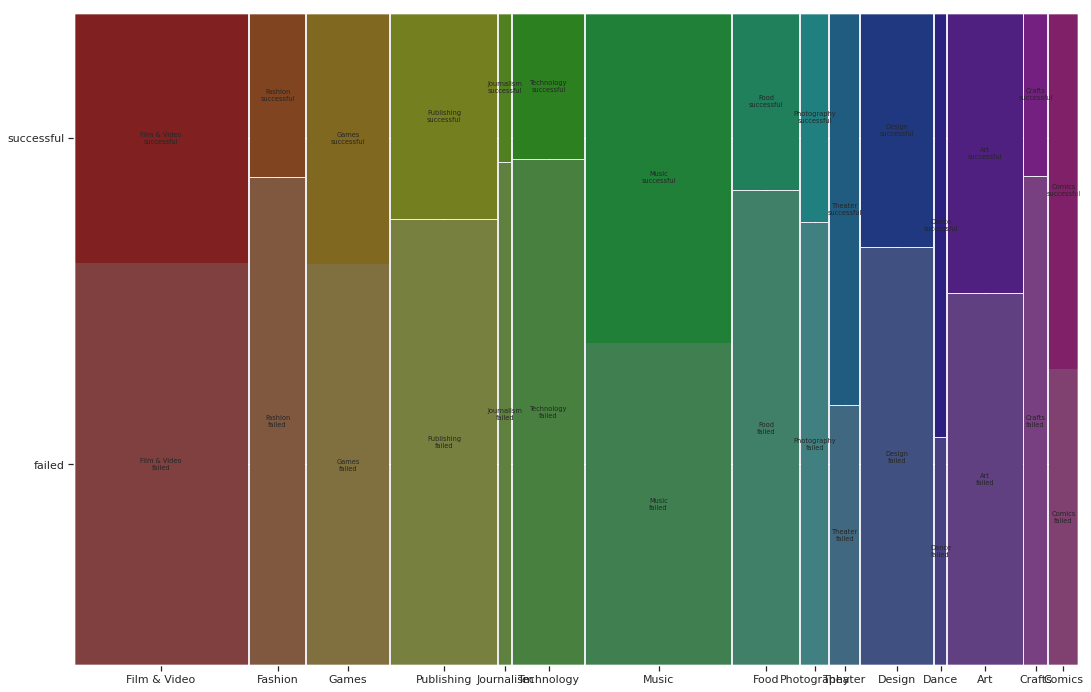

In [25]:
# Mosaic plot 
plt.rcParams['figure.figsize']=(18,12)
plt.rcParams['font.size'] = 8.0
mosaic(kick1.sort_values('state'), ['main_category', 'state'], axes_label=True, gap=0.002)
plt.show

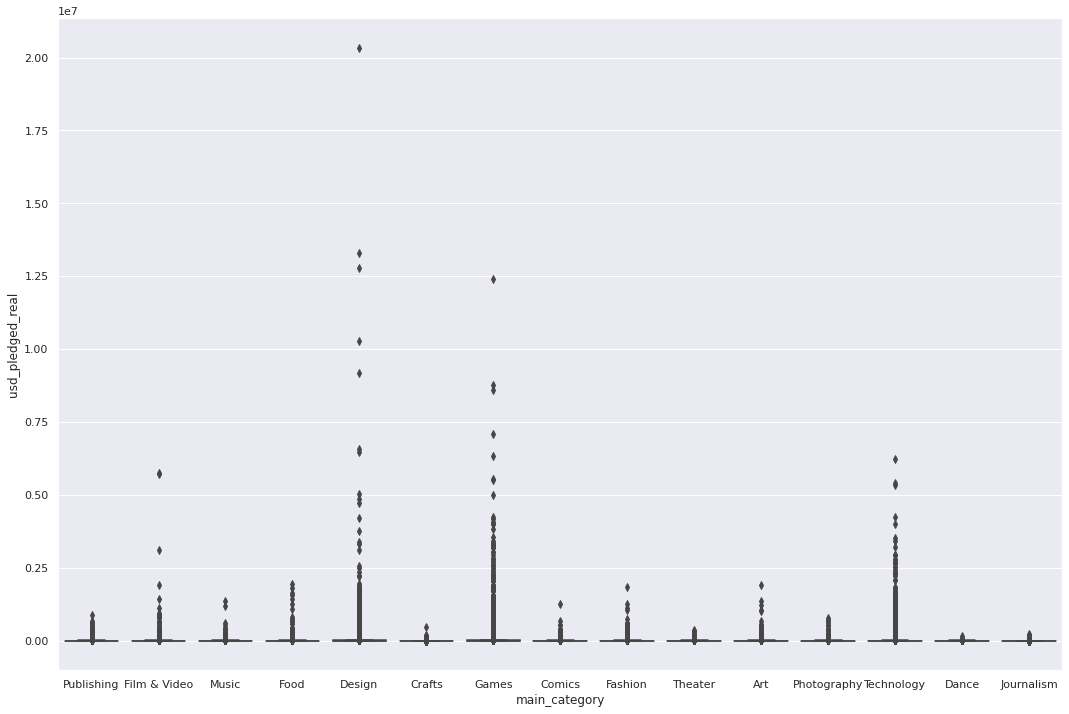

In [26]:
sns.boxplot(x=kick_base["main_category"], y=kick_base["usd_pledged_real"], data=kick_base);
plt.show()

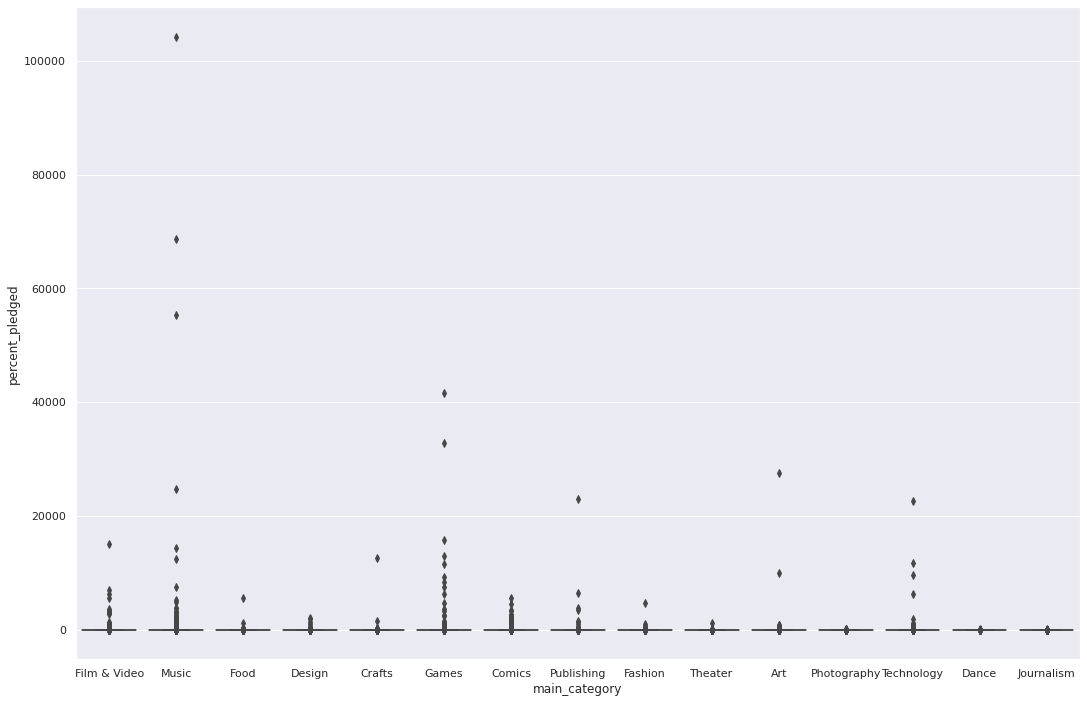

In [28]:
# extreme variation, outlier analysis needed
sns.boxplot(x=kick1["main_category"], y=kick1["percent_pledged"], data=kick1);
plt.show()

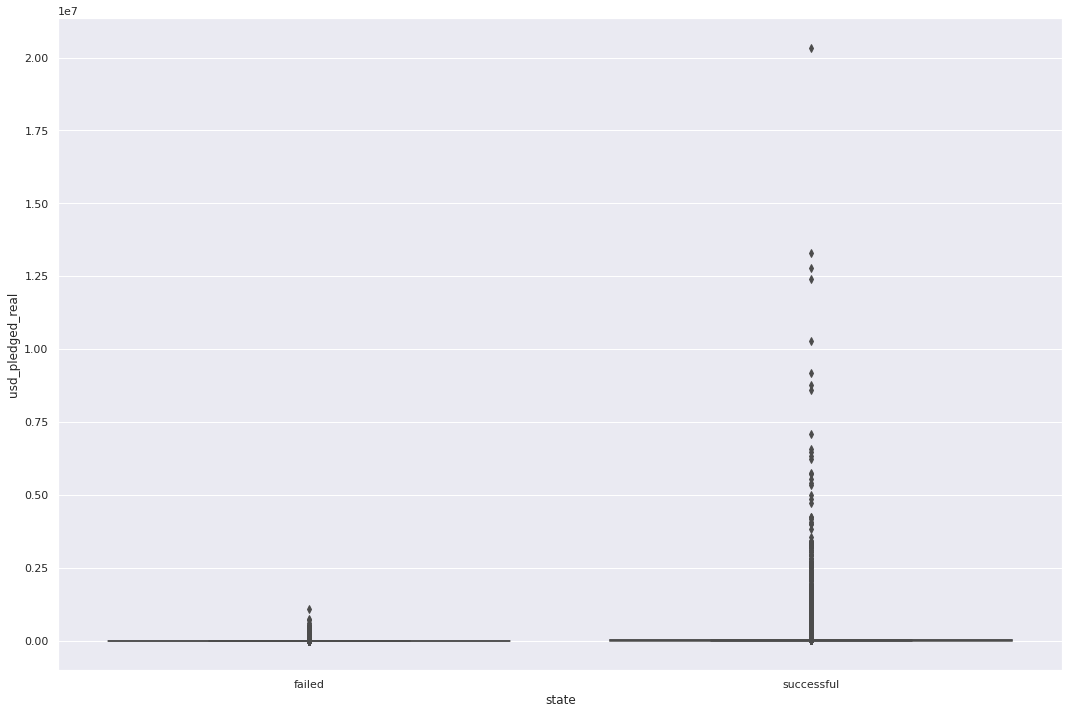

In [29]:
sns.boxplot(x=kick1["state"], y=kick1["usd_pledged_real"], data=kick1);
plt.show()

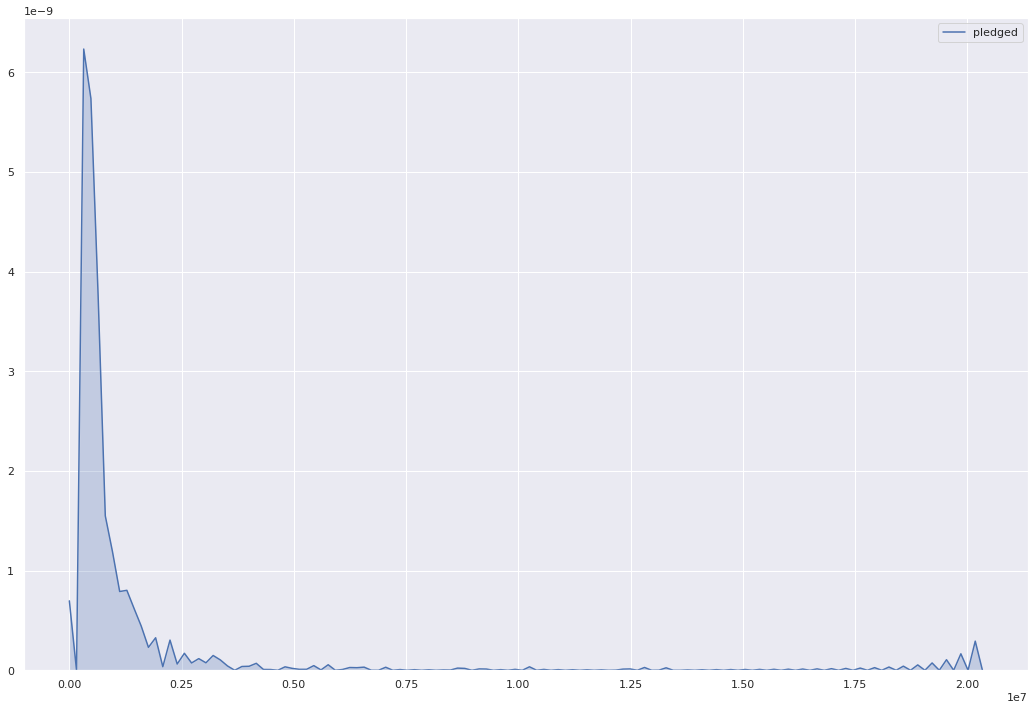

In [35]:
sns.kdeplot(kick1["pledged"],shade=True)

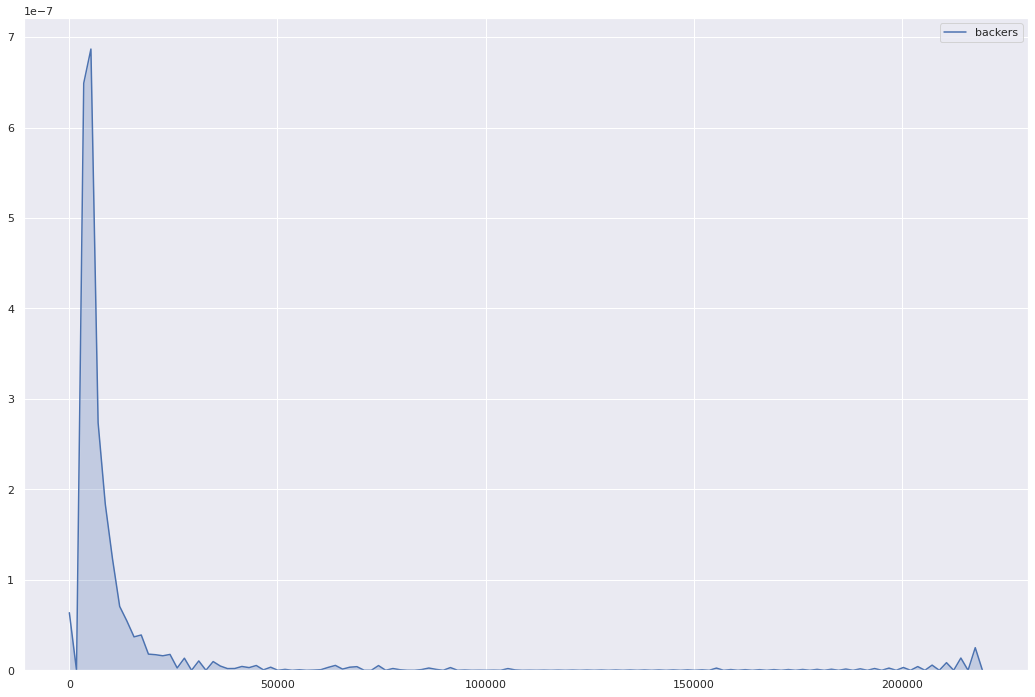

In [34]:
sns.kdeplot(kick1["backers"],shade=True)

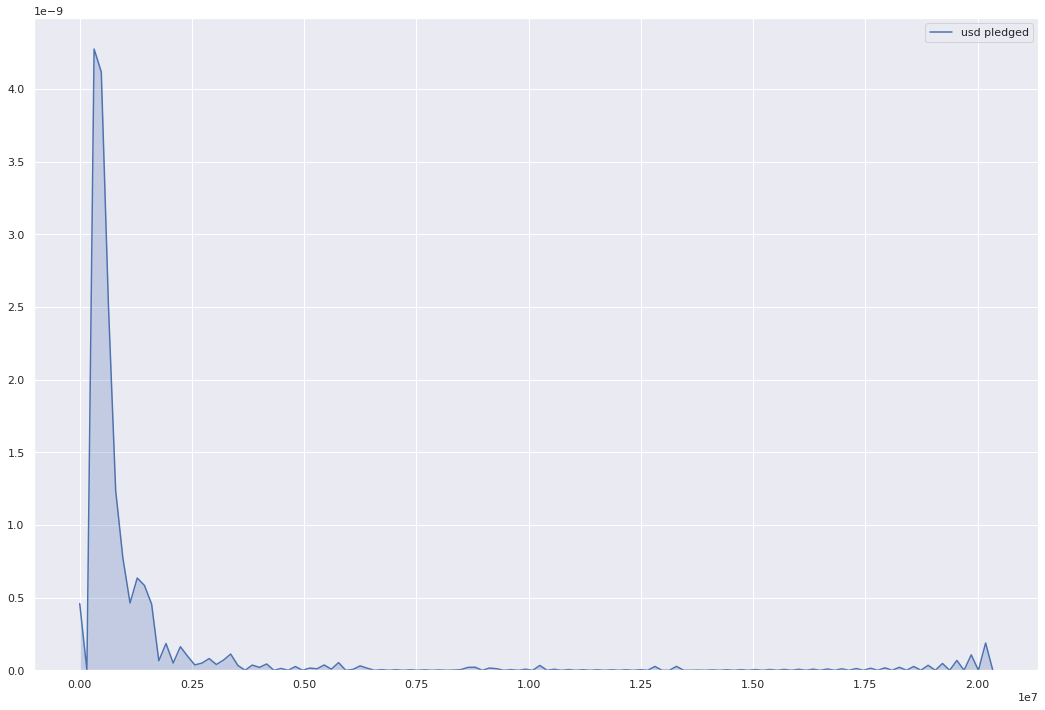

In [33]:
sns.kdeplot(kick1["usd pledged"],shade=True)

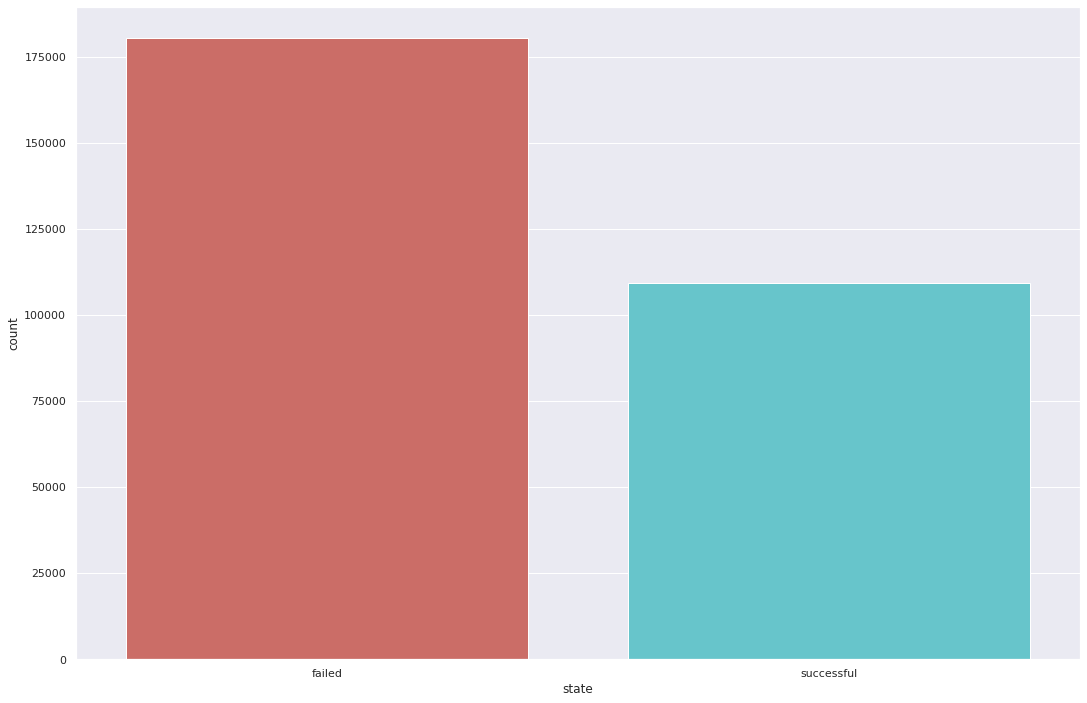

In [36]:
# https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
sns.countplot(x='state',data = kick1, palette = 'hls')
plt.show()
#plt.savefig('success_counts')

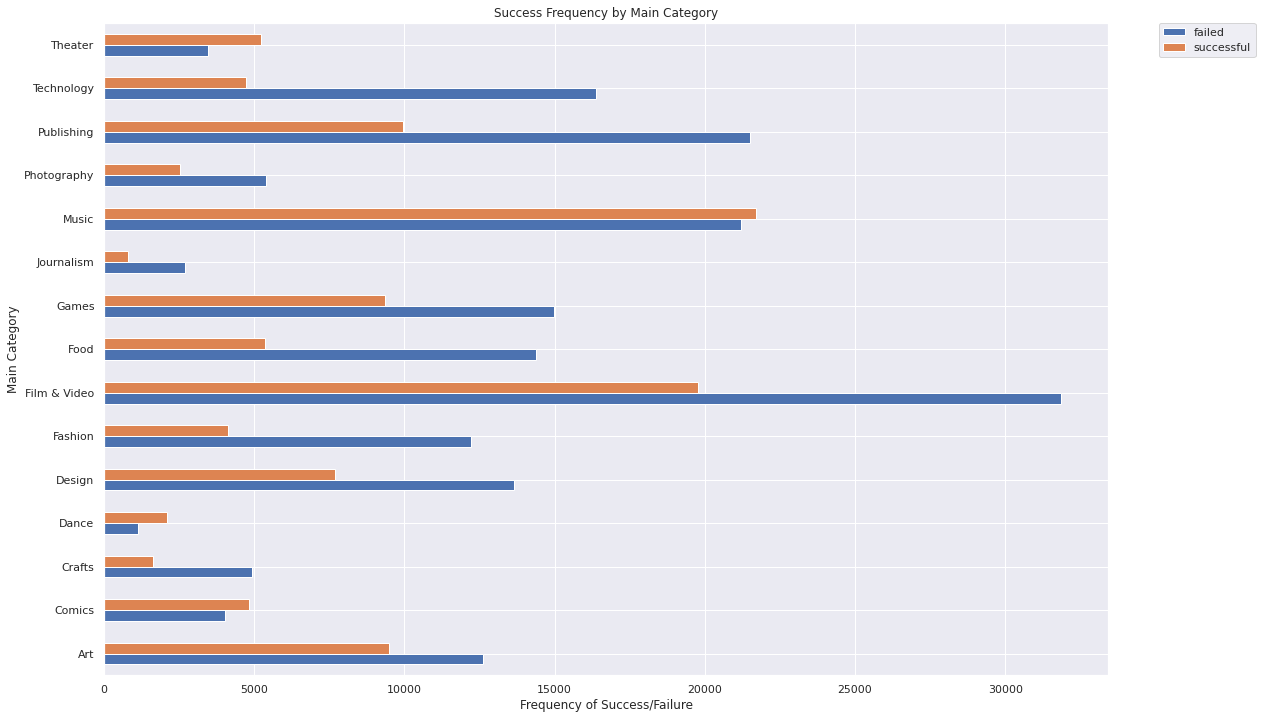

In [37]:
# https://mode.com/example-gallery/python_horizontal_bar/
pd.crosstab(kick1.main_category,kick1.state).plot(kind='barh')
plt.title('Success Frequency by Main Category')
plt.xlabel('Frequency of Success/Failure')
plt.ylabel('Main Category')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.savefig('cat_success_freq')

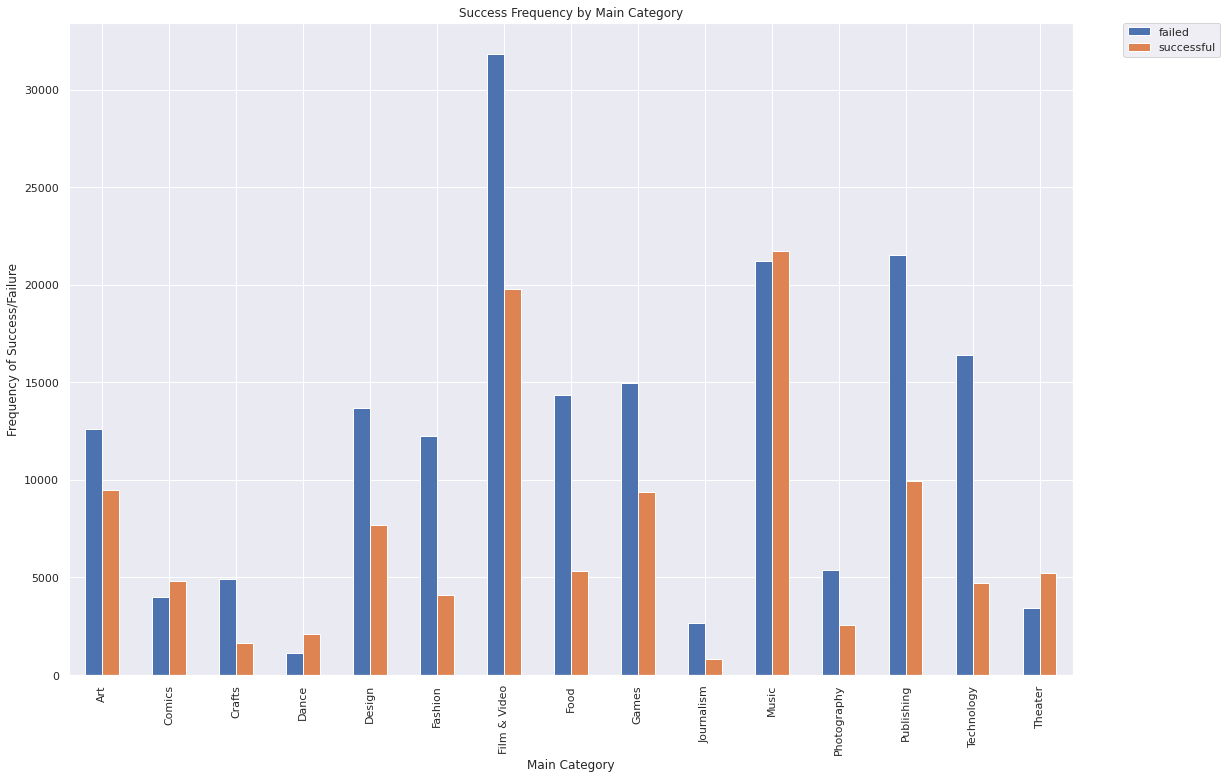

In [38]:
pd.crosstab(kick1.main_category,kick1.state).plot(kind='bar')
plt.title('Success Frequency by Main Category')
plt.xlabel('Main Category')
plt.ylabel('Frequency of Success/Failure')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.savefig('cat_success_freq')

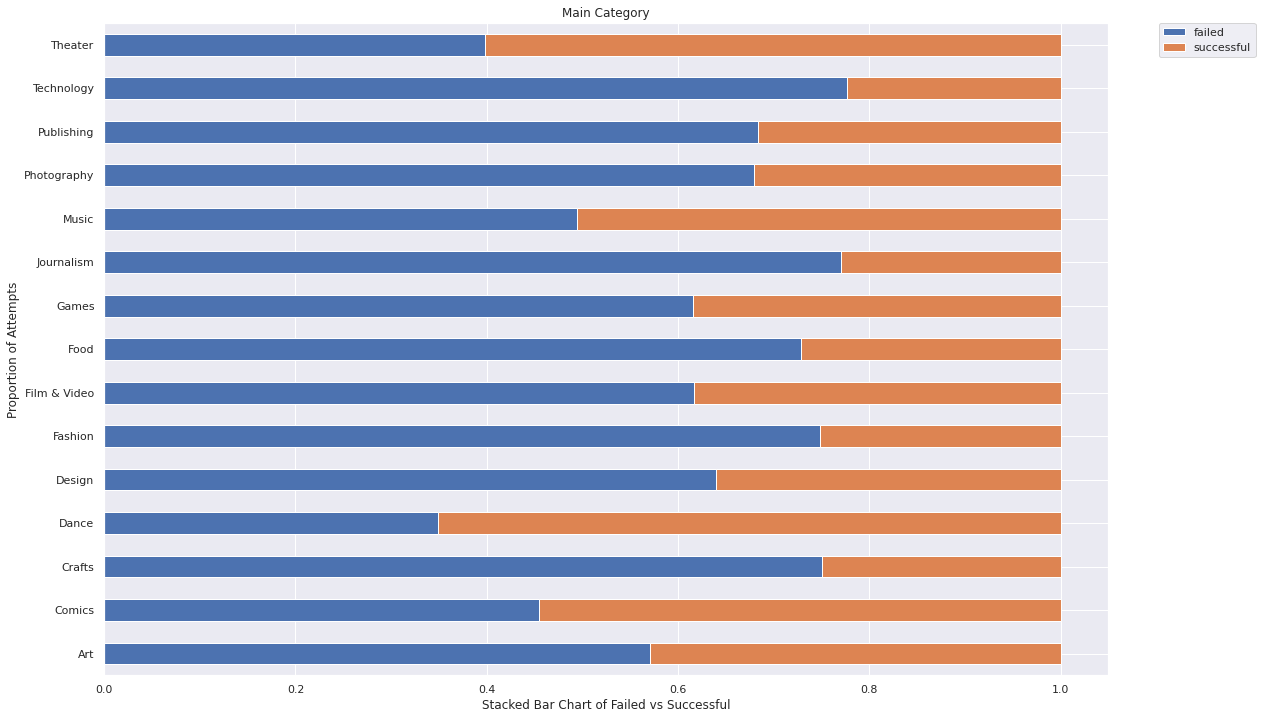

In [39]:
table=pd.crosstab(kick1.main_category,kick1.state)
table.div(table.sum(1).astype(float), axis=0).plot(kind='barh', stacked=True)
plt.title('Main Category')
plt.xlabel('Stacked Bar Chart of Failed vs Successful')
plt.ylabel('Proportion of Attempts')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.savefig('')

# Building Linear Regression Model

In [40]:
np.random.seed(1234)
kick1['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(kick1))
kick1_train = kick1[kick1['runiform'] >= 0.33]
kick1_test = kick1[kick1['runiform'] < 0.33]
# check training data frame
#print('\nkick1_train data frame (rows, columns): ',kick1_train.shape)
#print(kick1_train.head())
# check test data frame
#print('\nkick1_test data frame (rows, columns): ',kick1_test.shape)
#print(kick1_test.head())

# specify a simple model with bobblehead entered last
my_model_1 = str('percent_pledged ~ funds_to_length + goal') # main_category +

# fit the model to the training set
train_model_fit_1 = smf.ols(my_model_1, data = kick1_train).fit()
# summary of model fit to the training set
print(train_model_fit_1.summary())
# training set predictions from the model fit to the training set
kick1_train['predict_percent_pledged'] = train_model_fit_1.fittedvalues
#print(kick1_train)


                            OLS Regression Results                            
Dep. Variable:        percent_pledged   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.02610
Date:                Fri, 28 Aug 2020   Prob (F-statistic):              0.974
Time:                        21:07:17   Log-Likelihood:            -1.3625e+06
No. Observations:              194060   AIC:                         2.725e+06
Df Residuals:                  194057   BIC:                         2.725e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.6548      0.616     

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [40]:
# test set predictions from the model fit to the training set
kick1_test['predict_percent_pledged'] = train_model_fit_1.predict(kick1_test)
print(kick1_test)

                ID  ... predict_percent_pledged
1       1000003930  ...                1.484239
6       1000023410  ...                0.698935
7       1000030581  ...                0.696112
20      1000072011  ...                0.796884
31      1000117861  ...                1.895368
...            ...  ...                     ...
378623   999800713  ...                1.487662
378629   999814955  ...                0.697582
378634   999867839  ...                0.637414
378637   999878813  ...                1.486519
378643   999931480  ...                2.551066

[95611 rows x 21 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
Film_Video_prediction = kick1_test[kick1_test.main_category == "Film & Video"]["predict_percent_pledged"].item()

# Building Logistic Model

In [ ]:
main_category = pd.get_dummies(kick1['main_category'],prefix='main_cat')
category = pd.get_dummies(kick1['category'], prefix = 'cat')
name = pd.get_dummies(kick1['name'], prefix = 'name')
country = pd.get_dummies(kick1['country'], prefix = 'country')
state = pd.get_dummies(kick1['state'], prefix = 'state')
currency = pd.get_dummies(kick1['currency'], prefix = 'currency')

kick1_modified = pd.concat([kick1, main_category, category, country, currency, name, state], axis=1)

In [1]:
kick1_modified.head()

NameError: ignored

In [22]:
# create dummies for categorical features
# https://www.edureka.co/blog/logistic-regression-in-python/
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,accuracy_score

y = data['Target']
X = data_modified[data_modified.columns.difference(['main_category','category','country','currency',
                                  'Target','name','deadline','deadline_date','launched_date',
                                  'launched','P>G','backers','pledged','state', 'usd pledged', 
                                  'usd_goal_real', 'usd_pledged_real','ID'])]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

x = kick1.drop('state2', axis=1)
y = kick1['state2']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)
logmodel = LogisticRegression()
logmodel.fit(x_train, y_train)
 
predictions = logmodel.predict(x_test)
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(accuracy_score(y_test, predictions))

ValueError: ignored

In [12]:
from sklearn.model_selection import train_test_split
np.random.seed(1234)

kick1['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(kick1))

kick1_train = kick1[kick1['runiform'] >= 0.33]
kick1_test = kick1[kick1['runiform'] < 0.33]

In [13]:
kick1_train.head()
np.shape(kick1_train)

(194060, 20)

In [14]:
kick1_test.head()
np.shape(kick1_test)

(95611, 20)

In [ ]:
#from sklearn.linear_model import LogisticRegression
#logreg = LogisticRegression()

In [ ]:
my_model_1 = str('State ~ percent_pledged + usd_goal_real' + 'fundraising_length' +	'funds_to_length')

In [ ]:
import statsmodels.api as sm
train_model_fit_1 = sm.Logit(my_model_1, data = kick1_train).fit()

TypeError: ignored

# SweetViz stuff

In [1]:
kick_base_report = sv.analyze(kick_base)

NameError: ignored